In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd

metadata_frame = pd.read_csv("/Users/lukasadamek/Projects/GenerativePlayground/datasets/unzipped/metadata.csv")

In [2]:
metadata_frame

,Unnamed: 0,image_shape,last_image_dimension,shape_dim_zero,shape_dim_one,filename
0,0,3,3,800,532,/Users/lukasadamek/Projects/GenerativePlaygrou...
1,1,3,3,600,600,/Users/lukasadamek/Projects/GenerativePlaygrou...
2,2,3,3,1584,1002,/Users/lukasadamek/Projects/GenerativePlaygrou...
3,3,3,3,1754,1280,/Users/lukasadamek/Projects/GenerativePlaygrou...
4,4,3,3,600,600,/Users/lukasadamek/Projects/GenerativePlaygrou...
...,...,...,...,...,...,...
6968,6968,3,3,1024,683,/Users/lukasadamek/Projects/GenerativePlaygrou...
6969,6969,3,3,600,600,/Users/lukasadamek/Projects/GenerativePlaygrou...
6970,6970,3,3,636,500,/Users/lukasadamek/Projects/GenerativePlaygrou...
6971,6971,3,3,900,600,/Users/lukasadamek/Projects/GenerativePlaygrou...


In [3]:
len(metadata_frame.query("shape_dim_zero == shape_dim_one"))

1966

In [4]:
len(metadata_frame.query("(abs(shape_dim_zero - shape_dim_one)/shape_dim_one) < 0.15"))

2172

In [5]:
cleaned_frame = metadata_frame.query("(abs(shape_dim_zero - shape_dim_one)/shape_dim_one) < 0.15")
cleaned_frame = cleaned_frame.query("(image_shape == 3) and (last_image_dimension == 3) and (shape_dim_zero >= 500) and (shape_dim_one >= 500)")

In [6]:
import cv2

class ImageLoader:
    def __init__(self, file_list, resize = None, return_fname = False, black_and_white=True):
        self.file_list = file_list
        self.resize = resize
        self.black_and_white = black_and_white
    
    def __getitem__(self, i):
            img, filename = plt.imread(self.file_list[i]), self.file_list[i]
            if self.resize is not None:
                img = cv2.resize(img, (600, 600), interpolation=cv2.INTER_AREA)
            if self.black_and_white:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img.reshape((600, 600, 1))
            img = img / 255.0
            return img, filename
    
    def __len__(self):
        return len(self.file_list)


In [7]:
loader = ImageLoader(cleaned_frame["filename"].values, resize=(600,600))

In [8]:
loader[0][0]

array([[[0.23529412],
        [0.23137255],
        [0.23137255],
        ...,
        [0.38431373],
        [0.38039216],
        [0.38039216]],

       [[0.22745098],
        [0.22352941],
        [0.22352941],
        ...,
        [0.38431373],
        [0.38431373],
        [0.38431373]],

       [[0.23137255],
        [0.23137255],
        [0.22745098],
        ...,
        [0.38431373],
        [0.38431373],
        [0.38431373]],

       ...,

       [[0.07843137],
        [0.07843137],
        [0.07843137],
        ...,
        [0.32156863],
        [0.31764706],
        [0.31764706]],

       [[0.08235294],
        [0.08235294],
        [0.08235294],
        ...,
        [0.32156863],
        [0.31764706],
        [0.31372549]],

       [[0.08627451],
        [0.08627451],
        [0.08627451],
        ...,
        [0.31764706],
        [0.31372549],
        [0.30980392]]])

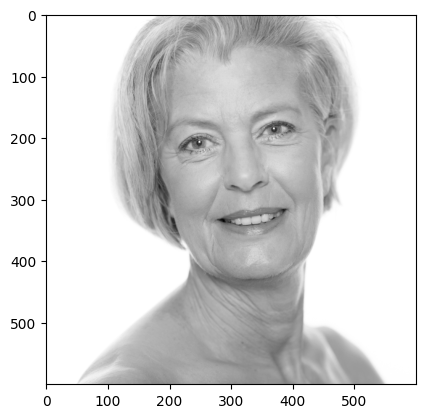

In [9]:
plt.imshow(loader[505][0], cmap="gray")

In [10]:
import tensorflow as tf
import tensorflow.keras as keras

generator = keras.models.Sequential()
generator.add(keras.layers.Conv2D(1, (5, 5), padding="SAME", activation='linear', input_shape=(5,5,1)))
generator.add(keras.layers.LeakyReLU(alpha=0.1))
generator.add(keras.layers.Conv2DTranspose(2, (10, 10), strides=5, padding="VALID", activation='linear'))
generator.add(keras.layers.LeakyReLU(alpha=0.1))
generator.add(keras.layers.Dropout(0.1))
generator.add(keras.layers.Conv2DTranspose(3, (12, 12), strides=2, padding="VALID", activation='linear'))
generator.add(keras.layers.LeakyReLU(alpha=0.1))
generator.add(keras.layers.Conv2DTranspose(3, (12, 12), strides=2, padding="VALID", activation='linear'))
generator.add(keras.layers.LeakyReLU(alpha=0.1))
generator.add(keras.layers.Conv2DTranspose(6, (12, 12), strides=4, padding="VALID", activation='linear'))
generator.add(keras.layers.LeakyReLU(alpha=0.1))
generator.add(keras.layers.Dropout(0.1))
generator.add(keras.layers.Conv2D(3, (20, 20), padding="SAME", activation='linear'))
generator.add(keras.layers.LeakyReLU(alpha=0.1))
generator.add(keras.layers.Conv2D(1, (20, 20), padding="SAME", activation='sigmoid'))
generator.add(keras.layers.Cropping2D(4))

scorer = keras.models.Sequential()
scorer.add(keras.layers.Conv2D(6, (3, 3), activation='linear', input_shape=(600, 600, 1)))
scorer.add(keras.layers.LeakyReLU(alpha=0.1))
scorer.add(keras.layers.MaxPooling2D((4, 4)))
scorer.add(keras.layers.Conv2D(6, (5, 5), activation='linear'))
scorer.add(keras.layers.LeakyReLU(alpha=0.1))
scorer.add(keras.layers.MaxPooling2D((4, 4)))
scorer.add(keras.layers.Dropout(0.1))
scorer.add(keras.layers.Conv2D(1, (5, 5), activation='linear'))
scorer.add(keras.layers.LeakyReLU(alpha=0.1))
scorer.add(keras.layers.MaxPooling2D((4, 4)))
scorer.add(keras.layers.Flatten())
scorer.add(keras.layers.Dense(1, activation="linear"))

2023-06-12 17:58:41.650172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 1)           26        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 5, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 2)        202       
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 30, 2)         0         
                                                                 
 dropout (Dropout)           (None, 30, 30, 2)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 70, 70, 3)        867       
 ranspose)                                              

In [12]:
scorer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 598, 598, 6)       60        
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 598, 598, 6)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 6)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 145, 145, 6)       906       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 145, 145, 6)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 6)        0         
 2D)                                                  

In [13]:
import numpy as np
import keras

class RealDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_loader, batch_size=12, image_size=(600,600)):
        self.image_loader = image_loader
        self.batch_size = batch_size
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.image_loader) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        data = np.stack([self.image_loader[i][0] for i in indexes])
        return data, np.ones(len(data))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_loader))
        np.random.shuffle(self.indexes)

class FakeDataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size=12, shape=(5, 5, 1), length=1000, generator=None, limit=None):
        self.length=length
        self.batch_size=batch_size
        self.shape=shape
        self.on_epoch_end()
        self.generator=generator
        self.limit=limit
    
    def __len__(self):
        return min(self.length, self.limit)
    
    def __getitem__(self, index):
        to_return = np.random.uniform(low=0.0, high=1.0, size=(self.batch_size, *self.shape))
        if self.generator is not None:
            return self.generator(to_return).numpy(), np.zeros(shape=(self.batch_size))
        else:
            return to_return, np.zeros(shape=(self.batch_size))
    
    def on_epoch_end(self):
        pass

class MergedDataGenerator(keras.utils.Sequence):
    def __init__(self, gen1, gen2, limit=20):
        self.gen1=gen1
        self.gen2=gen2
        self.limit=limit
    
    def __len__(self):
        return min(len(self.gen1), self.limit)
    
    def __getitem__(self, index):
        x1, y1 = self.gen1[index]
        x2, y2 = self.gen2[index]
        return np.concatenate([x1,x2]), np.concatenate([y1,y2])
    
    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()

In [14]:
real_generator = RealDataGenerator(loader, batch_size=4)
fake_generator = FakeDataGenerator(batch_size=4, length=len(real_generator), generator=generator)
fake_seed_generator = FakeDataGenerator(batch_size=4, length=len(real_generator), generator=None, limit=20)
full_generator = MergedDataGenerator(real_generator, fake_generator)

In [15]:
real_generator[0][0].shape

(4, 600, 600, 1)

In [16]:
fake_generator[0][0].shape

(4, 600, 600, 1)

In [17]:
class ConditionalGAN(keras.Model):
    def __init__(self, critic, generator, mode="GEN", clip=0.5):
        super().__init__()
        self.generator = generator
        self.critic = critic
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.clip = clip
        self.mode=mode

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn_gen, loss_fn_critic):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn_gen = loss_fn_gen
        self.loss_fn_critic = loss_fn_critic

    def train_step(self, data):
        x, y = data
        
        # Train the critic.
        if self.mode == "CRITIC":
            with tf.GradientTape() as tape:
                criticized_real = self.critic(x[y==1])
                criticized_fake = self.critic(x[y==0])
                d_loss = self.loss_fn_critic(criticized_real, criticized_fake)
                grads = tape.gradient(d_loss, self.critic.trainable_weights)
                self.d_optimizer.apply_gradients(
                    zip(grads, self.critic.trainable_weights)
                )
                for w in self.critic.trainable_variables:
                    w.assign(tf.clip_by_value(w, -self.clip, self.clip))
            self.disc_loss_tracker.update_state(d_loss)
            return {
                "d_loss": self.disc_loss_tracker.result(),
            }
        #else:
        #    criticized_real = self.critic(x[y==1])
        #    criticized_fake = self.critic(x[y==0])
        #    d_loss = self.loss_fn_critic(criticized_real, criticized_fake)
            

        # Train the generator.
        if self.mode == "GEN": 
            with tf.GradientTape() as tape:
                criticized_fake = self.critic(self.generator(x[y==0]))
                g_loss = self.loss_fn_gen(criticized_fake)
                grads = tape.gradient(g_loss, self.generator.trainable_weights)
                self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
            self.gen_loss_tracker.update_state(g_loss)
            return {
                "g_loss": self.gen_loss_tracker.result(),
            }
        #else:
        #    criticized_fake = self.critic(self.generator(x[y==0]))
        #    g_loss = self.loss_fn_gen(criticized_fake)
            

        # Monitor loss.


cond_gen = ConditionalGAN(
    scorer, generator, mode="GEN"
)

cond_critic = ConditionalGAN(
    scorer, generator, mode="CRITIC"
)

def critic_loss(criticized_real, criticized_fake):
    return  (-1) * tf.math.reduce_mean(criticized_real) + tf.math.reduce_mean(criticized_fake)

def generator_loss(criticized_fake):
    return (-1) * tf.math.reduce_mean(criticized_fake)

cond_gen.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss_fn_gen=generator_loss,
    loss_fn_critic=critic_loss,
)

cond_critic.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss_fn_gen=generator_loss,
    loss_fn_critic=critic_loss,
)


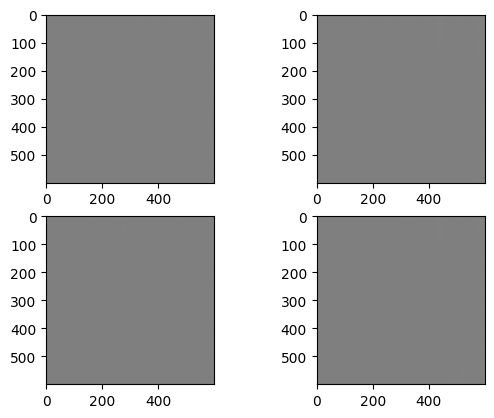

2023-06-12 17:58:54.042469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 94s 5s/step - d_loss: 0.0262
Epoch 1/3


2023-06-12 18:00:27.666155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 362s 18s/step - g_loss: -0.0856
Epoch 2/3
20/20 [==============================] - 413s 21s/step - g_loss: -0.0954
Epoch 3/3
20/20 [==============================] - 370s 18s/step - g_loss: -0.1249


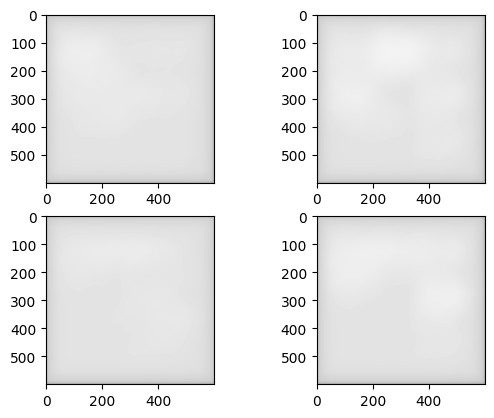

2023-06-12 18:19:36.719324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 99s 5s/step - d_loss: 0.0657
Epoch 1/3


2023-06-12 18:21:15.741386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 348s 17s/step - g_loss: -0.0834
Epoch 2/3
20/20 [==============================] - 342s 17s/step - g_loss: -0.0887
Epoch 3/3
20/20 [==============================] - 332s 17s/step - g_loss: -0.0908


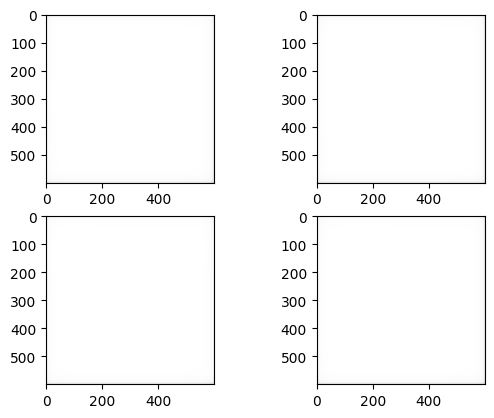

2023-06-12 18:38:20.990404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 93s 5s/step - d_loss: 0.0470
Epoch 1/3


2023-06-12 18:39:54.475722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 316s 16s/step - g_loss: -0.0528
Epoch 2/3
20/20 [==============================] - 305s 15s/step - g_loss: -0.0529
Epoch 3/3
20/20 [==============================] - 305s 15s/step - g_loss: -0.0529


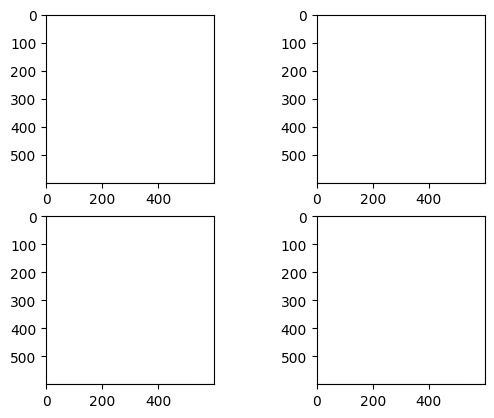

2023-06-12 18:55:23.316923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 85s 4s/step - d_loss: 0.0263
Epoch 1/3


2023-06-12 18:56:47.925365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 312s 16s/step - g_loss: -0.0300
Epoch 2/3
20/20 [==============================] - 348s 17s/step - g_loss: -0.0300
Epoch 3/3
20/20 [==============================] - 369s 18s/step - g_loss: -0.0301


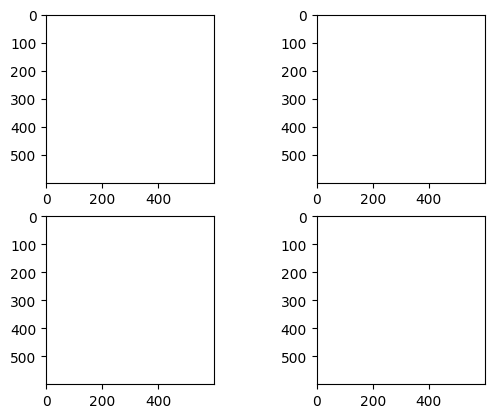

2023-06-12 19:14:00.879374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 104s 5s/step - d_loss: 0.0129
Epoch 1/3


2023-06-12 19:15:45.354197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 358s 18s/step - g_loss: -0.0141
Epoch 2/3
13/20 [==================>...........] - ETA: 2:01 - g_loss: -0.0141

In [ ]:
for i in range(0, 100):

    for i in range(1, 5):
        plt.subplot(2,2,i)
        plt.imshow(generator(np.random.uniform(low=0.0, high=1.0, size=(1, *(5,5,1))))[0].numpy(), cmap="gray", vmin=0.0, vmax=1.0)
    plt.show()
    cond_critic.fit(full_generator, epochs=1)
    cond_gen.fit(fake_seed_generator, epochs=3)